In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append('/solver/')
import solver

from solver.Mesh import *
from solver.SolverField import *
from solver.aux_solver import *
from solver.SbnSolver import *
from solver.DigitalTwin import *

# 1. Simulation of 2 laser beams propagating inside an SBN crystal

In [2]:
### arrayfire configuration
print('Available Backends -> ', af.get_available_backends())

###set backend and device
af.set_backend('cuda')
af.set_device(0)

###print info
print(af.info_str())


Available Backends ->  ('cuda', 'opencl')
ArrayFire v3.6.1 (CUDA 64bit)
[0] : GeForce_GTX_1050 (Compute 6.1)



## 1.1. Some Auxiliary Functions

In [3]:
def phase_slip(x,y,A,w,x0,y0,vx,vy,width):
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**4) *np.exp((
                         ((x-x0)<0)*1j*np.pi))
    
    return new_field

def super_gauss(x,y,A,w,x0,y0,vx,vy,width,phase=0,x00=0,y00=0):
    aux = (((x - x0)*(x - x0)+ (y - y0)*(y - y0)) <= ( 0.8**2* (w*w)))
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**2)+1e-6
    new_field = new_field * (np.exp((1j*((vx*(x-x00))+(vy*(y-y00)))*aux)+1j*phase))
    return new_field

def whitenoise_2d_field_1(x,A):
    new_field = A*(0.5-np.random.rand(x.shape[0],x.shape[1]))*2         
    return new_field

def whitenoise_2d_field(x,A):
    new_field = np.random.normal(0,scale=A, size=(x.shape[0],x.shape[1]))#
    return new_field

def whitenoise_1d_field(x,A):
    new_field = np.random.normal(0,scale=A, size=(x.shape[0]))#
    return new_field


def periodic_noise(y,A,k):
    new_field = A*np.sin(k*y)    
    return new_field

## 1.2. Configure Simulator and run

$$ i \partial_z E_{1} + \frac{1}{2} \nabla ^{2}_{\perp} E_{1} + c_{1} \Delta n_{max} \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_1+ \alpha E_1 = 0$$
$$ i \partial_z E_{2} + \frac{1}{2\gamma} \nabla ^{2}_{\perp} E_{2} + c_{2} \Delta n_{max} \gamma \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_2+ \alpha E_2 = 0$$

![image](image.png)

$\Delta n_{max} = \frac{1}{2}n_{e}^{3}V/d$ with $d=5mm$ being the crystal width. The typical crystal length is around 2cm.

## 1.3. Setting up a 1D simulation

delta_n -> 0.0001235560064
lx -> 302.4397292938621
ly -> 226.81088976051322
lz -> 58.37032210723811
healing length - > 7.012273216965854e-05
dx-> 0.5907025962770744 dy-> 226.81088976051322
total steps to simulate -> 583
(512,)
(512,)
sound velocity 0.4472135954999579 0.0


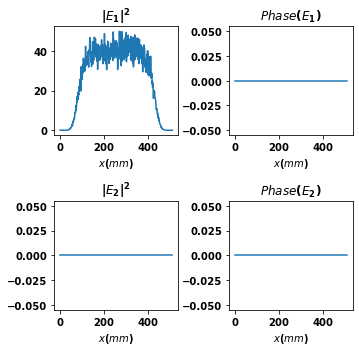

In [4]:
# Simulation Box to match experiment
pixel_pitch = 1.25e-6
magnification = 200/60
x_camera = np.arange(0,4000)*pixel_pitch  #micrometers
y_camera = np.arange(0,3000)*pixel_pitch


## Crystal
lx=x_camera[-1]/ magnification
ly=y_camera[-1]/ magnification
lz=20e-3
n_passages = 2  ###modify to increase the propagtion length

## start digital twin model
c1 = 1 #rxx / r33
c2 = 1 # rxx / r33
V=400
Isat = 200 #mW/cm2


###initialize the system
SBN_sim = DigitalTwin(lx=lx,ly=ly,lz=n_passages * lz,
                      V=V,c1=c1,c2=c2,Isat=Isat,
                      alpha=0)


###Save data dir 
saveDir = r'E:\\Quarmen\\'

SBN_sim.start_simulation_config(Nx=512,Ny=1,dz=0.01,dims=1,save_dir=saveDir,stride=10) ###dims = 1 as a 1d simulation


#######################################################################################
#############State Initialization######################################################
#######################################################################################

If1=40 #mw/cm^2

factor_t = SBN_sim.factor_t

SUPER_GAUSS_EXP = 4

X, Y = SBN_sim.xx, SBN_sim.yy
X -= X.max()/2
Y -= Y.max()/2


########################################################
#################   E1    ##############################
########################################################

velocity = 0.0e4 *(200/60) / factor_t 

gaussian_beam = np.zeros(np.shape(X)) + 0j

wx1 = 800e-6 * factor_t  ### micrometers * factor_t
wy1 = 800e-6 * factor_t

x_pos = 0
y_pos = 0

gaussian_beam += np.exp(-((2.0* (
                        (X - x_pos) ** 2.0 / (wx1**2.0)
                    +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                        ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j

gaussian_beam*=np.exp(1j*velocity*X)

gaussian_beam*=np.sqrt(If1)

##add white noise
A_noise=0.05
try:
    gaussian_beam = gaussian_beam*(1+whitenoise_2d_field(X,A_noise))
except:
    gaussian_beam = gaussian_beam*(1+whitenoise_1d_field(X,A_noise))
SBN_sim.field1.add_field_numpy(gaussian_beam)


########################################################
#################   E2    ##############################
########################################################


If2=0

v2 = 0

gaussian_beam = np.zeros(np.shape(X)) + 0j

print("sound velocity", np.sqrt(If1/Isat), velocity)

gaussian_beam*=np.sqrt(If2)
A_noise=0.02
try:
    gaussian_beam = gaussian_beam*(1+whitenoise_2d_field(X,A_noise))
except:
    gaussian_beam = gaussian_beam*(1+whitenoise_1d_field(X,A_noise))


SBN_sim.field2.add_field_numpy(gaussian_beam)

SBN_sim.plot()

In [5]:
simulate = True
if simulate:
    SBN_sim.run()

Stride 0 of 583
Stride 1 of 583
Stride 2 of 583
Stride 3 of 583
Stride 4 of 583
Stride 5 of 583
Stride 6 of 583
Stride 7 of 583
Stride 8 of 583
Stride 9 of 583
Stride 10 of 583
Stride 11 of 583
Stride 12 of 583
Stride 13 of 583
Stride 14 of 583
Stride 15 of 583
Stride 16 of 583
Stride 17 of 583
Stride 18 of 583
Stride 19 of 583
Stride 20 of 583
Stride 21 of 583
Stride 22 of 583
Stride 23 of 583
Stride 24 of 583
Stride 25 of 583
Stride 26 of 583
Stride 27 of 583
Stride 28 of 583
Stride 29 of 583
Stride 30 of 583
Stride 31 of 583
Stride 32 of 583
Stride 33 of 583
Stride 34 of 583
Stride 35 of 583
Stride 36 of 583
Stride 37 of 583
Stride 38 of 583
Stride 39 of 583
Stride 40 of 583
Stride 41 of 583
Stride 42 of 583
Stride 43 of 583
Stride 44 of 583
Stride 45 of 583
Stride 46 of 583
Stride 47 of 583
Stride 48 of 583
Stride 49 of 583
Stride 50 of 583
Stride 51 of 583
Stride 52 of 583
Stride 53 of 583
Stride 54 of 583
Stride 55 of 583
Stride 56 of 583
Stride 57 of 583
Stride 58 of 583
Stride 

## 2. Analysis

## 2.1 Load Data

In [6]:
from solver.af_loader import *


sim_state = []
sim_state2 = []

zz= []
n_state=400
for passage in range(1, n_state):
    saveDir = saveDir
    print(saveDir)
    my_mesh = mesh(saveDir+"\\")
    stride_read = 1

    ntotalfiles = len([f for f in os.listdir(saveDir+"\\gnlse_field\\") if f.endswith('.af')])
    index = int(ntotalfiles * passage/n_state)-1

    print(ntotalfiles,passage/n_passages, (index+1)/ntotalfiles)
    
    
    simulation_data,zs = load_data_folder(saveDir+"\\gnlse_field\\", my_mesh,index=1,stride_read=stride_read, index_to_read = index)
    simulation_data2,zs = load_data_folder(saveDir+"\\gnlse_field2\\",my_mesh, index=2, stride_read=stride_read, index_to_read = index)
    
    sim_state.append(np.transpose(simulation_data[0]))
    sim_state2.append(np.transpose(simulation_data2[0]))
    zz.append(zs[0])

    
sim_state=np.array(sim_state)
sim_state2=np.array(sim_state2)

E:\\Quarmen\\
584 0.5 0.0017123287671232876
E:\\Quarmen\\
584 1.0 0.003424657534246575
E:\\Quarmen\\
584 1.5 0.00684931506849315
E:\\Quarmen\\
584 2.0 0.008561643835616438
E:\\Quarmen\\
584 2.5 0.011986301369863013
E:\\Quarmen\\
584 3.0 0.0136986301369863
E:\\Quarmen\\
584 3.5 0.017123287671232876
E:\\Quarmen\\
584 4.0 0.018835616438356163
E:\\Quarmen\\
584 4.5 0.02226027397260274
E:\\Quarmen\\
584 5.0 0.023972602739726026
E:\\Quarmen\\
584 5.5 0.0273972602739726
E:\\Quarmen\\
584 6.0 0.02910958904109589
E:\\Quarmen\\
584 6.5 0.030821917808219176
E:\\Quarmen\\
584 7.0 0.03424657534246575
E:\\Quarmen\\
584 7.5 0.03595890410958904
E:\\Quarmen\\
584 8.0 0.039383561643835614
E:\\Quarmen\\
584 8.5 0.0410958904109589
E:\\Quarmen\\
584 9.0 0.04452054794520548
E:\\Quarmen\\
584 9.5 0.046232876712328765
E:\\Quarmen\\
584 10.0 0.04965753424657534
E:\\Quarmen\\
584 10.5 0.05136986301369863
E:\\Quarmen\\
584 11.0 0.0547945205479452
E:\\Quarmen\\
584 11.5 0.05650684931506849
E:\\Quarmen\\
584 12.0 

## 2.2 Plot States

Text(0, 0.5, '$z(mm)$')

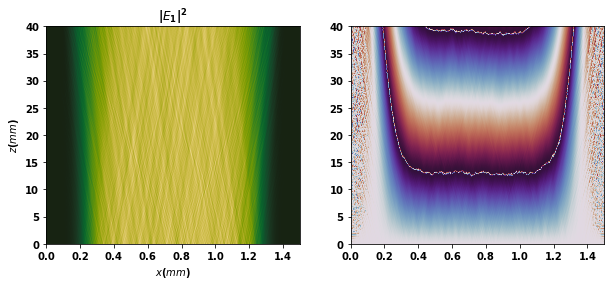

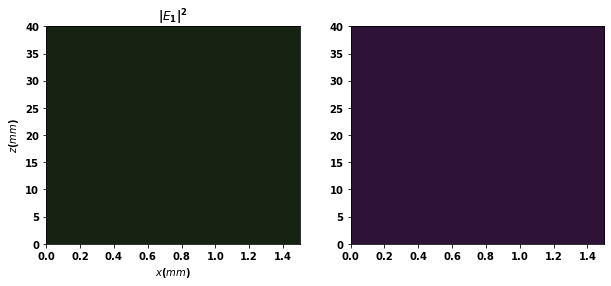

In [7]:
from solver.analysis_auxiliary_functions import *
import cmocean

fig,ax = plt.subplots(1,2,figsize=[10,4])
extent = [0,SBN_sim.lx*1e3,0,SBN_sim.lz*1e3]

ax[0].set_title(r'$|E_1|^2$')
ax[0].imshow(np.abs(sim_state)**2, aspect='auto', extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[1].imshow(np.angle(sim_state), aspect='auto', extent = extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$z(mm)$')

fig,ax = plt.subplots(1,2,figsize=[10,4])
extent = [0,SBN_sim.lx*1e3,0,SBN_sim.lz*1e3]

ax[0].set_title(r'$|E_1|^2$')
ax[0].imshow(np.abs(sim_state2)**2, aspect='auto', extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[1].imshow(np.angle(sim_state2), aspect='auto', extent = extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$z(mm)$')


In [8]:
%matplotlib widget

fig,ax = plt.subplots(1,1,figsize=[10,4])


fft_sim = np.fft.fftshift(np.fft.fft2(If1-np.abs(sim_state)**2))+ np.fft.fftshift(np.fft.fft2(If2-np.abs(sim_state2)**2))
#fft_sim = np.fft.fftshift(np.fft.fft2(If2-np.abs(sim_state2)**2))
kkx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(sim_state.shape[1],SBN_sim.lx/SBN_sim.Nx))
omega_z = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(sim_state.shape[0],SBN_sim.lz/sim_state.shape[0]))
ax.imshow(np.log10(np.abs(fft_sim)**2), aspect='auto',
          extent = [np.min(kkx),np.max(kkx),np.min(omega_z),np.max(omega_z)],
           origin='lower', cmap=plt.cm.inferno)

ax.set_xlabel(r'$k_x(m^{-1})$')
ax.set_ylabel(r'$\omega_z(m^{-1})$')

kx=np.linspace(-5,5,100)

fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Exercise1:  Fit the Bogoliubov Dispersion relation

Linearize this model
$$ i \partial_z E_{1} + \frac{1}{2} \nabla ^{2}_{\perp} E_{1} + c_{1} \Delta n_{max} \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_1+ \alpha E_1 = 0$$
taking E2=0, E1<<Isat, \alpha=0

$$ i \partial_z E_{1} + \frac{1}{2} \nabla ^{2}_{\perp} E_{1} + c_{1} \Delta n_{max} \frac{|E_1|^2}{I_{sat}} E_1= 0$$

in laboratory units we have

$$ \frac{i}{k} \partial_z E_{1} + \frac{1}{2 k^2 ne} \nabla ^{2}_{\perp} E_{1} + c_{1} \Delta n_{max} \frac{|E_1|^2}{I_{sat}} E_1= 0$$


k=2pi/lambda (lambda=532nm) ne=2.33

## 3. Setting up a 2D simulation

In [9]:
# Simulation Box to match experiment
pixel_pitch = 1.25e-6
magnification = 200/60
x_camera = np.arange(0,4000)*pixel_pitch  #micrometers
y_camera = np.arange(0,3000)*pixel_pitch



## Crystal
lx=x_camera[-1]/ magnification
ly=y_camera[-1]/ magnification
lz=20e-3
n_passages = 3 ###increase to see more dynamics, but in reality we have just 1

## start digital twin model
c1 = 1 #rxx / r33
c2 = 40/250 # rxx / r33
V=400
Isat = 200 #mW/cm2

SBN_sim = DigitalTwin(lx=lx,ly=ly,lz=n_passages * lz,
                      V=V,c1=c1,c2=c2,Isat=Isat,
                      alpha=0)

saveDir = 'E:\\Quarmen2d\\'

SBN_sim.start_simulation_config(Nx=256,Ny=256,dz=0.05,dims=2, save_dir=saveDir,stride=25)


#######################################################################################
#############State Initialization######################################################
#######################################################################################

If1=40

factor_t = SBN_sim.factor_t

SUPER_GAUSS_EXP = 2

X, Y = SBN_sim.xx, SBN_sim.yy
X -= X.max()/2
Y -= Y.max()/2


########################################################
#################   E1    ##############################
########################################################

velocity = 6.0e4 *(200/60) / factor_t 

gaussian_beam = np.zeros(np.shape(X)) + 0j

wx1 = 600e-6 * factor_t
wy1 = 600e-6 * factor_t

x_pos = -0* 200e-6 * factor_t
y_pos = 0

gaussian_beam += np.exp(-((2.0* (
                        (X - x_pos) ** 2.0 / (wx1**2.0)
                    +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                        ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j

gaussian_beam*=np.exp(1j*velocity*X)

print("sound velocity ->", np.sqrt(If1/Isat), "fluid velocity ->", velocity)

gaussian_beam*=np.sqrt(If1)

A_noise=0.1
gaussian_beam = gaussian_beam*(1+whitenoise_2d_field(X,A_noise))
SBN_sim.field1.add_field_numpy(gaussian_beam)


########################################################
#################   E2    ##############################
########################################################

If2=30

v2 = 0

gaussian_beam = np.zeros(np.shape(X)) + 0j

wx1 = 40e-6 * factor_t
wy1 = 40e-6 * factor_t

x_pos = 0
y_pos = 0

gaussian_beam += np.exp(-((2.0* (
                        (X - x_pos) ** 2.0 / (wx1**2.0)
                    +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                        ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j

gaussian_beam*=np.exp(1j*v2*X)

print("sound velocity", np.sqrt(If1/Isat), velocity)

gaussian_beam*=np.sqrt(If2)
A_noise=0.01
gaussian_beam = gaussian_beam*(1+whitenoise_2d_field(X,A_noise))


SBN_sim.field2.add_field_numpy(gaussian_beam)

SBN_sim.plot()

delta_n -> 0.0001235560064
lx -> 302.4397292938621
ly -> 226.81088976051322
lz -> 87.55548316085716
healing length - > 7.012273216965854e-05
dx-> 1.1814051925541489 dy-> 0.8859800381270048
total steps to simulate -> 70
(256, 256)
(256, 256)
sound velocity -> 0.4472135954999579 fluid velocity -> 0.9916851886498724
sound velocity 0.4472135954999579 0.9916851886498724


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
simulate = True
if simulate:
    SBN_sim.run()

Stride 0 of 70
Stride 1 of 70
Stride 2 of 70
Stride 3 of 70
Stride 4 of 70
Stride 5 of 70
Stride 6 of 70
Stride 7 of 70
Stride 8 of 70
Stride 9 of 70
Stride 10 of 70
Stride 11 of 70
Stride 12 of 70
Stride 13 of 70
Stride 14 of 70
Stride 15 of 70
Stride 16 of 70
Stride 17 of 70
Stride 18 of 70
Stride 19 of 70
Stride 20 of 70
Stride 21 of 70
Stride 22 of 70
Stride 23 of 70
Stride 24 of 70
Stride 25 of 70
Stride 26 of 70
Stride 27 of 70
Stride 28 of 70
Stride 29 of 70
Stride 30 of 70
Stride 31 of 70
Stride 32 of 70
Stride 33 of 70
Stride 34 of 70
Stride 35 of 70
Stride 36 of 70
Stride 37 of 70
Stride 38 of 70
Stride 39 of 70
Stride 40 of 70
Stride 41 of 70
Stride 42 of 70
Stride 43 of 70
Stride 44 of 70
Stride 45 of 70
Stride 46 of 70
Stride 47 of 70
Stride 48 of 70
Stride 49 of 70
Stride 50 of 70
Stride 51 of 70
Stride 52 of 70
Stride 53 of 70
Stride 54 of 70
Stride 55 of 70
Stride 56 of 70
Stride 57 of 70
Stride 58 of 70
Stride 59 of 70
Stride 60 of 70
Stride 61 of 70
Stride 62 of 70
St

## 2. Analysis

## 2.1 Load Data

In [20]:
from solver.af_loader import *


sim_state = []
sim_state2 = []

zz= []
n_state=20
for passage in range(0, n_state):
    saveDir = saveDir
    print(saveDir)
    my_mesh = mesh(saveDir+"\\")
    stride_read = 1

    ntotalfiles = len([f for f in os.listdir(saveDir+"\\gnlse_field\\") if f.endswith('.af')])
    index = int(ntotalfiles * passage/n_state)-1

    print(ntotalfiles,passage/n_passages, (index+1)/ntotalfiles)
    
    
    simulation_data,zs = load_data_folder(saveDir+"\\gnlse_field\\", my_mesh,index=1,stride_read=stride_read, index_to_read = index)
    simulation_data2,zs = load_data_folder(saveDir+"\\gnlse_field2\\",my_mesh, index=2, stride_read=stride_read, index_to_read = index)
    
    sim_state.append(np.transpose(simulation_data[0]))
    sim_state2.append(np.transpose(simulation_data2[0]))
    zz.append(zs[0])

    
sim_state=np.array(sim_state)
sim_state2=np.array(sim_state2)

E:\Quarmen2d\
71 0.0 0.0
E:\Quarmen2d\
71 0.3333333333333333 0.04225352112676056
E:\Quarmen2d\
71 0.6666666666666666 0.09859154929577464
E:\Quarmen2d\
71 1.0 0.14084507042253522
E:\Quarmen2d\
71 1.3333333333333333 0.19718309859154928
E:\Quarmen2d\
71 1.6666666666666667 0.23943661971830985
E:\Quarmen2d\
71 2.0 0.29577464788732394
E:\Quarmen2d\
71 2.3333333333333335 0.3380281690140845
E:\Quarmen2d\
71 2.6666666666666665 0.39436619718309857
E:\Quarmen2d\
71 3.0 0.43661971830985913
E:\Quarmen2d\
71 3.3333333333333335 0.49295774647887325
E:\Quarmen2d\
71 3.6666666666666665 0.5492957746478874
E:\Quarmen2d\
71 4.0 0.5915492957746479
E:\Quarmen2d\
71 4.333333333333333 0.647887323943662
E:\Quarmen2d\
71 4.666666666666667 0.6901408450704225
E:\Quarmen2d\
71 5.0 0.7464788732394366
E:\Quarmen2d\
71 5.333333333333333 0.7887323943661971
E:\Quarmen2d\
71 5.666666666666667 0.8450704225352113
E:\Quarmen2d\
71 6.0 0.8873239436619719
E:\Quarmen2d\
71 6.333333333333333 0.9436619718309859


## 2.2 Plot States

In [22]:
from solver.analysis_auxiliary_functions import *
import cmocean

index_plot = 5
z_value = zz[index_plot]/SBN_sim.factor_z*1e2
extent = [0,SBN_sim.lx*1e3,0,SBN_sim.ly*1e3]

fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_1|^2$')
ax[0].imshow(np.abs(sim_state[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')

ax[1].set_title(r'$\phi_1$')
ax[1].imshow(np.angle(sim_state[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_2|^2$')
im = ax[0].imshow(np.abs(sim_state2[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=plt.cm.gist_heat)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')
plt.colorbar(im)

ax[1].set_title(r'$\phi_2$')
ax[1].imshow(np.angle(sim_state2[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, '$y(mm)$')

## 2.3 Plot multiple states with ROI

In [23]:

######
######just some auxiliary functions

from mpl_toolkits.axes_grid1 import make_axes_locatable


def get_ROI_CM(state, wx,wy, factor_t, dx,dy):
    ##wx, wy in micrometers around center of mass
    width_x, width_y = wx*factor_t/dx,wy*factor_t/dy

    center_of_mass_x, center_of_mass_y = get_center_of_mass_index(state)
    ix0, ix1 = int(center_of_mass_x - int(width_x)/2), int(center_of_mass_x + int(width_x)/2) 
    iy0, iy1 = int(center_of_mass_y - int(width_y)/2), int(center_of_mass_y + int(width_y)/2)

    return {'ix_min':ix0, 'ix_max':ix1, 'iy_min':iy0, 'iy_max': iy1}


def simple_ticks(ax, extent, axis='xy'):

    yticks = [extent[2],extent[2]+(extent[3]-extent[2]) /2, extent[3]]
    blankyticks = ['' for i in yticks]
    ytickslabels = [np.str(int(i)) for i in yticks]
    print(yticks,ytickslabels)
    xticks = [extent[0],extent[0]+(extent[1]-extent[0])/2, extent[1]]
    blankxticks = ['' for i in yticks]
    xtickslabels = [np.str(int(i)) for i in xticks]
    
    
    if axis == None:
        ax.set_yticks(yticks)
        ax.set_yticklabels(blankyticks)
        ax.set_xticks(xticks)
        ax.set_xticklabels(blankxticks)
        ax.set_xlabel(r'')
        ax.set_ylabel(r'')



    elif axis == 'x':
        ax.set_yticks(yticks)
        ax.set_yticklabels(blankyticks)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtickslabels)
        ax.set_xlabel(r'$x(\mu m)$')
        ax.set_ylabel(r'')


    elif axis == 'y':
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytickslabels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(blankxticks)
        ax.set_xlabel(r'')
        ax.set_ylabel(r'$y(\mu m)$')


    else:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytickslabels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtickslabels)
        ax.set_xlabel(r'$x(\mu m)$')
        ax.set_ylabel(r'$y(\mu m)$')




def plot_intensity(ax, state, dx, dy, ROI=None,
                   colornorm = None, cmap=plt.cm.gist_heat,
                   z_value = None, plot_label = None, 
                    ticks='xy',title='$|E|^2$',vmin=0,vmax=None):

    if ROI == None:
        ROI = {'ix_min':0,'ix_max':state.shape[0],'iy_min':0,'iy_max':state.shape[1]}
    
    _lx =(ROI['ix_max']-ROI['ix_min'])* dx
    _ly = (ROI['iy_max']-ROI['iy_min']) * dy
    print(_lx)
    
    extent = [-_lx/2,_lx/2,-_ly/2,_ly/2]
    
    

    ax.set_title(title)
    im = ax.imshow(np.abs(state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, 
                   extent = extent, 
                   norm = colornorm, origin='lower', cmap=cmap,
                     vmin = vmin,vmax = vmax)

    simple_ticks(ax,extent, axis=ticks)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    cb = plt.colorbar(im,cax=cax)
    cb.ax.set_title(r'$I_f (mW/cm^2)$',fontsize=10)


    lz=20e-3
    if z_value != None:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.95, 0.05, r'$z = '+str(z_value/lz)+'L_z$', transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom',horizontalalignment='right', bbox=props)
    
    if plot_label != None:

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.05, 0.95, plot_label, transform=ax.transAxes, fontsize=12,color='w',
            verticalalignment='top',horizontalalignment='left', bbox=props)

    
def plot_phase(ax, state, dx, dy, ROI=None,
                   colornorm = None, cmap=plt.cm.twilight_shifted,
                   z_value = None, plot_label = None, 
                    ticks='xy',title='$\phi$'):

    if ROI == None:
        ROI = {'ix_min':0,'ix_max':state.shape[0],'iy_min':0,'iy_max':state.shape[1]}
        
    _xc = (ROI['ix_max']-ROI['ix_min'])/2 * dx
    _lx =(ROI['ix_max']-ROI['ix_min'])* dx

    _yc = (ROI['iy_max']-ROI['iy_min'])/2 * dy
    _ly = (ROI['iy_max']-ROI['iy_min']) * dy
    
    extent = [-_lx/2,_lx/2,-_ly/2,_ly/2]
    

    ax.set_title(title)
    
    phase_to_plot = np.angle(state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']]+0.1)
    #phase_to_plot = np.angle(0.1+state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']]*np.exp(-1j*(np.angle(np.mean(state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']][1500-10:1500+10,1500-10:1500+10]))+np.pi/2)))
    phase_to_plot = (phase_to_plot-1*np.pi)%(2*np.pi) - np.pi

    
    im = ax.imshow(phase_to_plot, aspect=SBN_sim.Nx / SBN_sim.Ny, 
                   extent = extent, 
                   norm = colornorm, origin='lower', cmap=cmap,
                     vmin = -np.pi,vmax = np.pi,interpolation='none')
    ax.set_xlabel(r'$x(\mu m)$')
    ax.set_ylabel(r'$y(\mu m)$')

    simple_ticks(ax,extent, axis=ticks)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    cb = plt.colorbar(im,cax=cax)
    cb.ax.set_title(r'$\phi (rad)$',fontsize=10)


    lz=20e-3
    if z_value != None:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.95, 0.05, r'$z = '+str(z_value/lz)+'L_z$', transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom',horizontalalignment='right', bbox=props)
    
    if plot_label != None:

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.05, 0.95, plot_label, transform=ax.transAxes, fontsize=12,color='w',
            verticalalignment='top',horizontalalignment='left', bbox=props)


In [24]:
## Ex make a plot with 2x2 = 4 panels with amplitude and phase for two distinct z side by side

plots_x, plots_y = 2,2
sizex = 4
sizey = 3
fig,ax=plt.subplots(plots_x,plots_y,figsize=[sizex*plots_x,sizey*plots_y])

list_z_index = [0,5]
for i,iz in enumerate(list_z_index):
    print(iz)
    #########Compute Region of interest##################
    ROI_state = get_ROI_CM(sim_state[iz], wx=600,wy=400, 
            factor_t=SBN_sim.factor_t,dx=SBN_sim.dx*1e6,dy=SBN_sim.dy*1e6)

    if i!=plots_x-1:
        ticks_amplitude = 'y'
        ticks_phase = None
    else: 
        ticks_amplitude = 'xy'
        ticks_phase = 'x'


    plot_intensity(ax[i,0],sim_state[iz],
                SBN_sim.dx/factor_t*1e6,SBN_sim.dy/factor_t*1e6,
                ROI=ROI_state,
                cmap=cmocean.cm.speed_r,plot_label='',z_value = np.round(zz[iz]/SBN_sim.factor_z,2),
                ticks=ticks_amplitude)

    plot_phase(ax[i,1],sim_state[iz],
            SBN_sim.dx/factor_t*1e6,SBN_sim.dy/factor_t*1e6,
            ROI=ROI_state,
            cmap=plt.cm.twilight_shifted,
            ticks=ticks_phase)

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0
597.5068359375
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']
5
597.5068359375
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']
